# Imports

In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [2]:
# # Define the names of the leads to use
# leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# # Initialize empty arrays to store the data and labels
# data = []
# labels = []

# # Specify the root directory
# root_dir = 'physionet/classification-of-12-lead-ecgs-the-physionetcomputing-in-cardiology-challenge-2020-1.0.2/training/ptb-xl/'

# # Loop over all directories from g1 to g22
# for i in range(1, 2): # TODO change to 23
#     print(f"analyzing folder {i}/22")

#     data_dir = os.path.join(root_dir, f'g{i}')
#     record_names = os.listdir(data_dir)
#     record_names.sort()
#     unique_files = set()

#     for file in record_names:
#         unique_files.add(os.path.splitext(file)[0])

#     # Loop over all records in the directory
#     for record_name in unique_files:
#         # Remove extension
#         filename = os.path.splitext(record_name)[0] 

#         # Load the raw ECG signal data from the .dat file
#         dat, fields = wfdb.rdsamp(os.path.join(data_dir, filename))
        
#         # Load the labels data from the .hea file
#         hea = wfdb.rdheader(os.path.join(data_dir, filename))

#         # Check if the sampling frequency is 500 Hz
#         if hea.fs != 500:
#             print(f"Sampling frequency for {filename} is not 500 Hz.")
#             continue
        
#         labels = hea.comments[2].split(': ')[1].split(',')
#         data.append({'record_name': filename, 'label': labels, 'signal': dat})

# df = pd.DataFrame(data)
# df.to_pickle('df_1000.pkl')

# Load the DataFrame from a pickle file
df = pd.read_pickle('df_processed_500.pkl')
from scipy import signal

# Assuming df is your DataFrame and 'signal' is the column with the signals
def resample_ecg_signal(signal_data):
    # Resample from 500 Hz to 250 Hz (downsample by a factor of 2)
    resampled_signal = signal.resample_poly(signal_data, up=1, down=2, axis=0)
    return resampled_signal

# Apply the resampling function to every signal in the DataFrame
df['signal'] = df['signal'].apply(resample_ecg_signal)
print(df)
print(df.loc[1,'signal'].shape)
df.to_pickle('df_processed_250.pkl')

# Now 'resampled_signal' column will have signals of shape (2500, 12)



                     record_name superclass  \
0      records500/00000/00001_hr   ['NORM']   
1      records500/00000/00002_hr   ['NORM']   
2      records500/00000/00003_hr   ['NORM']   
3      records500/00000/00004_hr   ['NORM']   
4      records500/00000/00005_hr   ['NORM']   
...                          ...        ...   
16239  records500/21000/21833_hr   ['STTC']   
16240  records500/21000/21834_hr   ['NORM']   
16241  records500/21000/21835_hr   ['STTC']   
16242  records500/21000/21836_hr   ['NORM']   
16243  records500/21000/21837_hr   ['NORM']   

                                                  signal    age  sex  
0      [[-0.08588371897207263, -0.03736346853162483, ...   56.0    1  
1      [[-0.011243299508205044, 0.09023407534582495, ...   19.0    0  
2      [[-0.02596508144425195, -0.052584897690685514,...   37.0    1  
3      [[-0.04137347387754445, -0.11622565135690588, ...   24.0    0  
4      [[-0.03003880948325483, -0.43121334841072106, ...   19.0    1  
...      

227.27272727272728


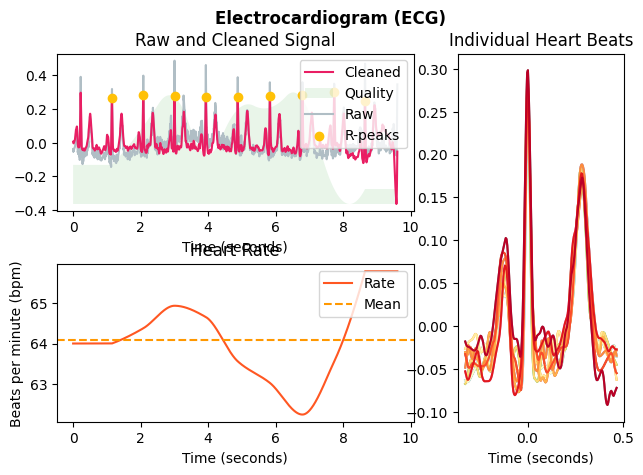

In [3]:
single_ecg = []
for sublist in df.loc[0,'signal']: #FIRST PATIENT
    single_ecg.append(sublist[1]) # LEAD II 

#inverted_ecg = nk.ecg_invert(flat_list, sampling_rate=500)
signals, info = nk.ecg_process(single_ecg, sampling_rate=250)
rpeaks = info["ECG_R_Peaks"]
#cleaned_ecg = signals["ECG_Clean"]

# Segment the ECG into individual heartbeats using the R-peaks
heartbeats = np.split(single_ecg, rpeaks)

# TODO check accuracy sans enlever le dernier beat
# Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats])
print(average_heartbeat_length)

if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
    heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete

# Concatenate the heartbeats back into a single ECG signal
cleaned_ecg = np.concatenate(heartbeats)
signals, info = nk.ecg_process(cleaned_ecg, sampling_rate=250)

#plot = nk.events_plot(rpeaks, cleaned_ecg) #WHole ecg

#epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=500, show=True) # beatss superimposed

#nk.ecg_plot(signals, sampling_rate=500) # summary of ecg
nk.ecg_plot(signals, sampling_rate=250) # summary of ecg
# _, waves_peak = nk.ecg_delineate(signals, # PQRS peaks
#                                  rpeaks, 
#                                  sampling_rate=500, 
#                                  method="peak", 
#                                  show=True, 
#                                  show_type='peaks')
